# Leaf classification with Gradient Boosting

TODO: improve this introductory section!

This notebook presents a practical overview about shape analysis and classification. 

The dataset are available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/leaf).

This notebook was splitted in the following sections:

1. Setup workspace
2. Load raw data
3. Image normalization
4. Feature extraction
5. Principal component analysis
6. Gradient boosting classifier
7. Results
8. Concluding remarks

## 1. Setup workspace

Set global options and import python packages:

In [1]:
#Some useful packages
import pathlib
import pandas
import random
import scipy
import numpy
import os
import re

#To read image files
import scipy.ndimage as scimg

#OpenCV image processing package
import cv2

#Plot tools
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as po

#Scikit learn
from sklearn.preprocessing import StandardScaler

%matplotlib inline
po.init_notebook_mode(connected=True)

## 2. Load the raw images

The raw images from the [UCI repository](https://archive.ics.uci.edu/ml/datasets/leaf) were added into the local folder: `./data/raw-images/`.

Here we scan all subdirectories and store each image in a numpy array:

In [2]:
#Raw data path
folder = "./data/raw-images/"

#Check subdirectories
subdirectories = list(map(str, [sb for sb in  pathlib.Path(folder).iterdir() if sb.is_dir()]))

#Load all images in each subdirectory
images = []
cat_id = 1
id = 1
for sb in subdirectories:
    filenames = os.listdir(sb)
    filenames = [fname for fname in filenames if re.match(".*.jpg", fname)]
    classname = os.path.basename(sb).lower()
    for fname in filenames:
        images.append({
                "id": id,
                "species_name": classname,
                "image": scimg.imread(sb + "/" + fname)})
        id += 1
    cat_id += 1

#Store labels for each image id 
labeltable = pandas.DataFrame(images, columns = ["id", "species_name"])

### 2.1 Example Plot

TODO: Plot 20

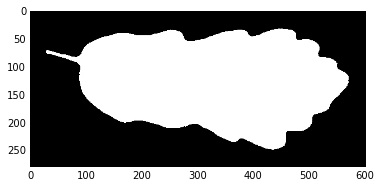

In [3]:
plt.imshow(images[0]["image"], cmap = "gray")

## 3. Image normalization and pre-processing

The raw images have different pixel sizes, which can be a problem for some features that are sensible to shifting.

In this section we insert all leaf images in a black background in such a way that all images have the same pixel size and the center of mass of each leaf matches the center of the global image.

### 3.1 Find a suitable image size

In [4]:
#Center of mass of each leaf
mass_centers = [tuple(map(int, scimg.measurements.center_of_mass(img["image"]))) for img in images]
#Shape of each raw image
im_shapes = [img["image"].shape for img in images]

#Find out a suitable image size to normalize images
max_height = numpy.array([2*max(im_shapes[i][0]-mass_centers[i][0], mass_centers[i][0]) for i in range(len(im_shapes))]).max()
max_width = numpy.array([2*max(im_shapes[i][1]-mass_centers[i][1], mass_centers[i][1]) for i in range(len(im_shapes))]).max()
max_width  = round(max_width+5, -1) + 1
max_height = round(max_height+5, -1) + 1

#Shape of normalized images
shape = (max_height, max_width)

#Center position of images
center = (int(max_height/2), int(max_width/2))

### 3.2 Save all images with the same size

In [5]:
#Destination folder of normalized images
folder = "./data/normalized-images/"

#Save images after normalization
for idx, img in enumerate(images):
    norm_image = numpy.zeros(shape)
    img_center = scimg.measurements.center_of_mass(img["image"])
    img_center = tuple([int(round(c)) for c in img_center])
    x0 = center[0]-img_center[0]
    y0 = center[1]-img_center[1]
    x1 = x0 + img["image"].shape[0]
    y1 = y0 + img["image"].shape[1]
    norm_image[x0:x1, y0:y1] = img["image"]
    scipy.misc.imsave(folder + str(img["id"]).zfill(4) + "_" + img["species_name"] + ".jpg", norm_image)

#Delete images to free memory
del images

## 4. Feature Engineering

### 4.1 Useful image features

#### 4.1 Area

TODO: explain area

#### 4.2 Solidity

TODO: explain Solidity

#### 4.3 Perimeter

TODO: explain perimeter

#### 4.4 Perimeter/Area

TODO: explain perimeter/area ratio

### 4.2 Extract image features

In [8]:
#Path to normalized images
folder = "./data/normalized-images/"

#Scan all files
filenames = os.listdir(folder)
filenames = [fname for fname in filenames if re.match(".*.jpg", fname)]
filenames.sort()
filenames = filenames[0:16*20] #subset

#Extract features for each image
features = []
for file in filenames:
    img =  scimg.imread(folder + file)
    ret, thresh = cv2.threshold(img, 127, 255, 0)
    img2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    contour = contours[numpy.array(list(map(len, contours))).argmax()]
    convex_hull = cv2.convexHull(contour)    
    x,y,w,h = cv2.boundingRect(contour)
    rect = cv2.minAreaRect(contour)
        
    area = cv2.contourArea(contour)
    rect_area = w*h
    extent = float(area)/rect_area
    convex_hull_area = cv2.contourArea(convex_hull)
    solidity = area/convex_hull_area
    perimeter = cv2.arcLength(contour,True)
    perimeter_area_ratio = perimeter/area
    aspect_ratio = float(w)/h
    equi_diameter = numpy.sqrt(4*area/numpy.pi)
    
    features.append([
            int(file[:4]),
            area,
            rect_area,
            extent,
            convex_hull_area,
            solidity,
            perimeter,
            perimeter_area_ratio,
            aspect_ratio,
            equi_diameter
            ])

### 4.3 Build the dataset

In [16]:
#Feature set
dataset = pandas.DataFrame(features, 
                           columns=["id", "area", "rect_area", "extent", "convex_hull_area", 
                                    "solidity", "perimeter", "perimeter_area_ratio", "aspect_ratio",
                                    "equi_diameter"])

#Add class label
dataset = pandas.merge(dataset, labeltable, how="left", on="id")

## 5. Principal Component Analysis

TODO: explain why we should use PCA

### 5.1 Extract principal components

In [17]:
#Inputs and outputs
X = dataset.ix[:,1:-1]
y = dataset.ix[:,-1]

#Scale normalization
X_std = StandardScaler().fit_transform(X)

#Compute covariance matrix, eigenvalues and eigenvectors
cov_mat = numpy.cov(X_std.T)
eig_vals, eig_vecs = numpy.linalg.eig(cov_mat)

#Compute principal components (PCA)
eig_pairs = [(numpy.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
matrix_w = numpy.hstack(tuple([ep[1].reshape(len(X.columns),1) for ep in eig_pairs]))
Y = X_std.dot(matrix_w)

### 5.2 Variance of principal components

In [18]:
#Compute self and cumulative variance of each PCA component
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = numpy.cumsum(var_exp)

#Plot variance of each component
trace1 = go.Bar(
        x=['PC %s' %i for i in range(1,Y.shape[1])],
        y=var_exp,
        showlegend=False)

trace2 = go.Scatter(
        x=['PC %s' %i for i in range(1,Y.shape[1])], 
        y=cum_var_exp,
        name='cumulative explained variance')

data = go.Data([trace1, trace2])

layout = go.Layout(
    title='Explained variance by different principal components',  
    hovermode="closest",
    yaxis=go.YAxis(title='Explained variance in percent'))

fig = go.Figure(data=data, layout=layout)
po.iplot(fig)

From the above plot we can see that 83% of the dataset variance can be retrieved

### 5.3 Scatter plot visualization (2 PCs)

In [19]:
traces = []

for name in numpy.unique(y):
    trace = go.Scatter(
        x=Y[y==name,0],
        y=Y[y==name,1],
        mode="markers",
        name=name,
        marker=go.Marker(
            size=12,
            line=go.Line(
                color="rgba(217, 217, 217, 0.14)",
                width=0.5),
            opacity=0.7))
    traces.append(trace)


data = go.Data(traces)

layout = go.Layout(
    title= "Leaf Species",
    hovermode= "closest",
    xaxis= dict(
        title= "Principal Component 1",
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= "Principal Component 2",
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig = go.Figure(data=data, layout=layout)
po.iplot(fig)

### 5.4 Scatter plot visualization (3 PCs)

From the previous plot we can see that with just 2 principal components it can be very diffucult to classify some leaf species. 

Let's try to visualize the first 3 principal components and see what we can get:

In [20]:
traces = []

for name in numpy.unique(y):
    trace = go.Scatter3d(
        x=Y[y==name,0],
        y=Y[y==name,1],
        z=Y[y==name,2],
        mode="markers",
        name=name,
        marker=go.Marker(
            size=12,
            line=go.Line(
                color="rgba(217, 217, 217, 0.14)",
                width=0.5),
            opacity=0.8))
    traces.append(trace)
   
layout = go.Layout(
    title= "Leaf Species",
    hovermode= "closest",
    xaxis= dict(
        title= "Principal Component 1",
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= "Principal Component 2",
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig = go.Figure(data=go.Data(traces), layout=layout)
po.iplot(fig)

## 6. Gradient Boosting Classifier

TODO: Implement Gradient Boosting Classifier

## 7. Results

TODO: present results (accuracy, confusion matrix, and so on)

## 8. Concluding remarks

TODO: Present some conclusions about this analysis